In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

In [3]:
# Define the Physics-Informed Neural Network Class
class PhysicsInformedNN:
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        """Initialization of the Physics-Informed Neural Network (PINN)
        
        Args:
            x0, u0, v0: Initial conditions for the PDE
            tb: Boundary condition points in time
            X_f: Collocation points (randomly sampled points in the domain)
            layers: Architecture of the neural network (list of layer sizes)
            lb, ub: Lower and upper bounds of the domain
        """
        self.lb = torch.tensor(lb, dtype=torch.float32)
        self.ub = torch.tensor(ub, dtype=torch.float32)

        # Convert inputs to tensors for initial and boundary conditions
        self.x0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
        self.t0 = torch.zeros_like(self.x0)  # Time is zero for initial condition
        
        self.u0 = torch.tensor(u0, dtype=torch.float32)  # Initial condition for u
        self.v0 = torch.tensor(v0, dtype=torch.float32)  # Initial condition for v

        self.x_lb = torch.zeros_like(torch.tensor(tb, dtype=torch.float32)) + lb[0]
        self.x_lb.requires_grad_()  # Ensure gradients are tracked
        self.t_lb = torch.tensor(tb, dtype=torch.float32, requires_grad=True)

        self.x_ub = torch.zeros_like(torch.tensor(tb, dtype=torch.float32)) + ub[0]
        self.x_ub.requires_grad_()  # Ensure gradients are tracked
        self.t_ub = torch.tensor(tb, dtype=torch.float32, requires_grad=True)

        # Collocation points in the domain
        self.x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32, requires_grad=True)
        self.t_f = torch.tensor(X_f[:, 1:2], dtype=torch.float32, requires_grad=True)

        # Define the neural network
        self.model = self.build_nn(layers)

        # Define optimizers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.lbfgs = torch.optim.LBFGS(
            self.model.parameters(), 
            max_iter=1000, 
            tolerance_grad=1e-10, 
            tolerance_change=1e-10,
            history_size=50
        )

    def build_nn(self, layers):
        """Creates a fully connected neural network.
        
        Args:
            layers: List defining the architecture of the network.
        Returns:
            A sequential model with specified layers and activation functions.
        """
        layers_list = []
        for i in range(len(layers) - 1):
            layers_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layers_list.append(nn.Tanh())  # Activation function
        return nn.Sequential(*layers_list)

    def net_uv(self, x, t):
        """Predicts u and v and computes their spatial derivatives.
        
        Args:
            x, t: Input tensors for space and time.
        Returns:
            u, v: Predicted values.
            u_x, v_x: Spatial derivatives.
        """
        X = torch.cat((x, t), dim=1).requires_grad_()  # Concatenate x and t
        X_scaled = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0  # Scale inputs to [-1, 1]
        uv = self.model(X_scaled)  # Forward pass through the network
        u, v = uv[:, 0:1], uv[:, 1:2]  # Extract u and v from the output
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # Compute spatial derivative of u
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Compute spatial derivative of v
        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        """Computes the residuals of the PDE.
        
        Args:
            x, t: Input tensors for space and time.
        Returns:
            f_u, f_v: Residuals for the PDE equations.
        """
        u, v, u_x, v_x = self.net_uv(x, t)  # Get u, v, and their derivatives
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # Time derivative of u
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]  # Second spatial derivative of u
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Time derivative of v
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]  # Second spatial derivative of v
        f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v  # Residual for u
        f_v = v_t - 0.5 * u_xx - (u**2 + v**2) * u  # Residual for v
        return f_u, f_v

    def loss_fn(self):
        """Defines the loss function combining data and physics losses.
        
        Returns:
            Total loss value.
        """
        u0_pred, v0_pred, _, _ = self.net_uv(self.x0, self.t0)  # Predictions for initial conditions
        u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb)  # Lower boundary
        u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.x_ub, self.t_ub)  # Upper boundary
        f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f)  # Collocation points residuals

        loss = torch.mean((self.u0 - u0_pred)**2) + torch.mean((self.v0 - v0_pred)**2)  # Initial condition loss
        loss += torch.mean((u_lb_pred - u_ub_pred)**2) + torch.mean((v_lb_pred - v_ub_pred)**2)  # Boundary loss
        loss += torch.mean((u_x_lb_pred - u_x_ub_pred)**2) + torch.mean((v_x_lb_pred - v_x_ub_pred)**2)  # Derivative continuity
        loss += torch.mean(f_u_pred**2) + torch.mean(f_v_pred**2)  # PDE residual loss
        return loss

    def train(self, nIter):
        prev_loss = float('inf')
        
        # Training with Adam optimizer
        for epoch in range(nIter):
            self.optimizer.zero_grad()
            loss = self.loss_fn()
            loss.backward()
            self.optimizer.step()

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.3e}")

        # Training with L-BFGS optimizer
        def closure():
            if torch.is_grad_enabled():
                self.lbfgs.zero_grad()
            loss = self.loss_fn()
            if loss.requires_grad:
                loss.backward()
            return loss

        print("Switching to L-BFGS optimizer...")
        self.lbfgs.step(closure)

    def predict(self, X_star):
        """Predict the solution u and v at given points.
        
        Args:
            X_star: Points where prediction is needed.
        Returns:
            Predicted u and v values.
        """
        X_star = torch.tensor(X_star, dtype=torch.float32, requires_grad=True)
        x_star, t_star = X_star[:, 0:1], X_star[:, 1:2]
        u_pred, v_pred, _, _ = self.net_uv(x_star, t_star)
        return u_pred.detach().numpy(), v_pred.detach().numpy()


In [5]:
# Function to load and preprocess data
def load_data():
    """Loads data from a MATLAB file and preprocesses it for training and evaluation.
    
    Returns:
        x, t, Exact_u, Exact_v, X_star, u_star, v_star: Processed data components.
    """
    data = scipy.io.loadmat('NLS.mat')
    t = data['tt'].flatten()[:, None]
    x = data['x'].flatten()[:, None]
    Exact = data['uu']
    Exact_u = np.real(Exact)
    Exact_v = np.imag(Exact)

    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact_u.T.flatten()[:, None]
    v_star = Exact_v.T.flatten()[:, None]

    return x, t, Exact_u, Exact_v, X_star, u_star, v_star

In [7]:
# Function to initialize training data
def initialize_training_data(x, t, Exact_u, Exact_v, lb, ub, N0, N_b, N_f):
    """Initializes training data for PINN.
    
    Args:
        x, t, Exact_u, Exact_v: Spatial, temporal, and exact solutions.
        lb, ub: Domain bounds.
        N0, N_b, N_f: Number of points for initial, boundary, and collocation conditions.
    Returns:
        x0, u0, v0, tb, X_f: Training data components.
    """
    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x, :]
    u0 = Exact_u[idx_x, 0:1]
    v0 = Exact_v[idx_x, 0:1]

    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t, :]

    X_f = lb + (ub - lb) * lhs(2, N_f)

    return x0, u0, v0, tb, X_f

In [9]:
# Main Execution
if __name__ == "__main__":
    # Domain bounds
    lb = np.array([-5.0, 0.0])
    ub = np.array([5.0, np.pi / 2])

    # Load and preprocess data
    x, t, Exact_u, Exact_v, X_star, u_star, v_star = load_data()

    # Initialize training data
    N0, N_b, N_f = 50, 50, 20000
    x0, u0, v0, tb, X_f = initialize_training_data(x, t, Exact_u, Exact_v, lb, ub, N0, N_b, N_f)

    # Model initialization
    layers = [2, 100, 100, 100, 100, 2]
    model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)

    # Train model
    start_time = time.time()
    model.train(1000)
    elapsed = time.time() - start_time
    print(f"Training time: {elapsed:.2f} seconds")

    # Predict and compute error
    u_pred, v_pred = model.predict(X_star)
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
    print(f"Error u: {error_u:.3e}")
    print(f"Error v: {error_v:.3e}")

Epoch 0, Loss: 5.947e-01
Epoch 10, Loss: 3.559e-01
Epoch 20, Loss: 3.363e-01
Epoch 30, Loss: 3.210e-01
Epoch 40, Loss: 2.967e-01
Epoch 50, Loss: 2.504e-01
Epoch 60, Loss: 2.005e-01
Epoch 70, Loss: 1.587e-01
Epoch 80, Loss: 1.278e-01
Epoch 90, Loss: 1.123e-01
Epoch 100, Loss: 1.023e-01
Epoch 110, Loss: 9.304e-02
Epoch 120, Loss: 8.554e-02
Epoch 130, Loss: 7.863e-02
Epoch 140, Loss: 7.294e-02
Epoch 150, Loss: 6.786e-02
Epoch 160, Loss: 6.404e-02
Epoch 170, Loss: 6.012e-02
Epoch 180, Loss: 5.615e-02
Epoch 190, Loss: 5.397e-02
Epoch 200, Loss: 5.496e-02
Epoch 210, Loss: 5.219e-02
Epoch 220, Loss: 5.040e-02
Epoch 230, Loss: 4.846e-02
Epoch 240, Loss: 5.288e-02
Epoch 250, Loss: 4.683e-02
Epoch 260, Loss: 4.563e-02
Epoch 270, Loss: 4.465e-02
Epoch 280, Loss: 4.357e-02
Epoch 290, Loss: 4.283e-02
Epoch 300, Loss: 4.288e-02
Epoch 310, Loss: 4.187e-02
Epoch 320, Loss: 4.163e-02
Epoch 330, Loss: 4.195e-02
Epoch 340, Loss: 4.003e-02
Epoch 350, Loss: 3.964e-02
Epoch 360, Loss: 3.885e-02
Epoch 370, L

In [11]:
def plot_results(x, t, X_star, u_star, v_star, u_pred, v_pred, Exact_u, Exact_v, lb, ub, x0, tb):
    """Plot the results comparing exact and predicted solutions."""
    # Compute magnitude |h| for exact and predicted values
    h_star = np.sqrt(u_star**2 + v_star**2)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    
    # Interpolation for visualization
    X, T = np.meshgrid(x, t)  # Create the grid
    xi = np.vstack([X.flatten(), T.flatten()]).T  # Flatten and stack as 2D array
    H_pred = griddata(X_star, h_pred.flatten(), xi, method='cubic')  # Interpolate
    H_pred = H_pred.reshape(X.shape)  # Reshape back to the grid
    Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
    
    # Training data points
    X0 = np.concatenate((x0, 0 * x0), 1)  # Initial condition
    X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # Lower boundary
    X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # Upper boundary
    X_u_train = np.vstack([X0, X_lb, X_ub])  # Combined training points

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    # Visualization: h(t, x)
    from matplotlib import gridspec
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1 - 0.06, bottom=1 - 1 / 3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(
        H_pred.T,
        interpolation='nearest',
        cmap='YlGnBu',
        extent=[lb[1], ub[1], lb[0], ub[0]],
        origin='lower',
        aspect='auto'
    )
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label=f"Data ({X_u_train.shape[0]} points)", markersize=4, clip_on=False)

    line = np.linspace(x.min(), x.max(), 2)[:, None]
    ax.plot(t[75] * np.ones((2, 1)), line, 'k--', linewidth=1)
    ax.plot(t[100] * np.ones((2, 1)), line, 'k--', linewidth=1)
    ax.plot(t[125] * np.ones((2, 1)), line, 'k--', linewidth=1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='best')
    ax.set_title('$|h(t,x)|$', fontsize=10)

    # Plot slices
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1 - 1 / 3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    for i, time_idx in enumerate([75, 100, 125]):
        ax = plt.subplot(gs1[0, i])
        ax.plot(x, Exact_h[:, time_idx], 'b-', linewidth=2, label='Exact')
        ax.plot(x, H_pred[time_idx, :], 'r--', linewidth=2, label='Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$|h(t,x)|$')
        ax.axis('square')
        ax.set_xlim([lb[0], ub[0]])
        ax.set_ylim([-0.1, 5.1])
        ax.set_title(f'$t = {t[time_idx][0]:.2f}$', fontsize=10)
        if i == 0:
            ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1, frameon=False)

    plt.tight_layout()
    plt.show()


/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_6363/3495702179.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


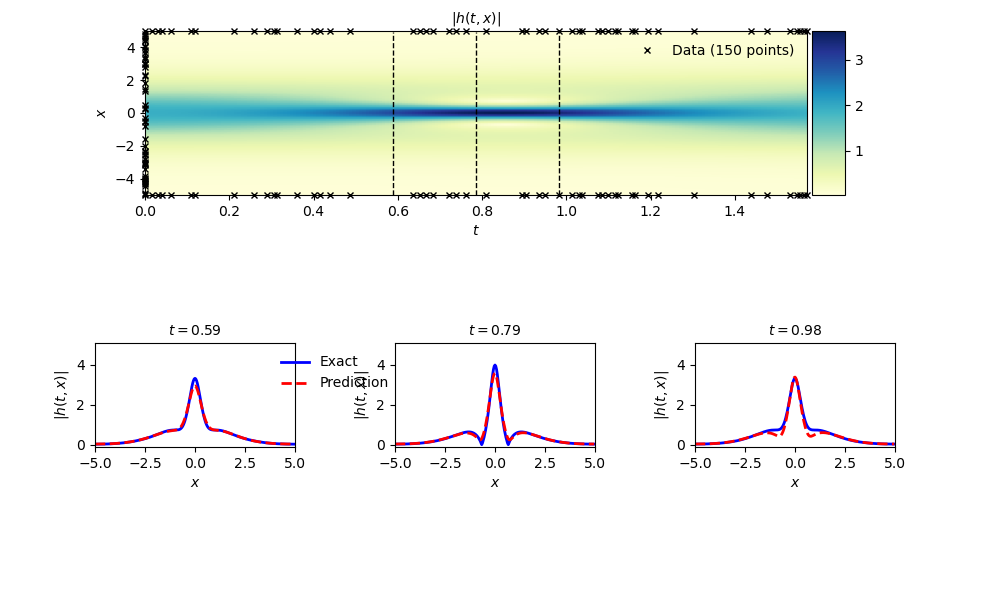

In [13]:
plot_results(
    x, t, X_star, u_star, v_star, u_pred, v_pred, 
    Exact_u, Exact_v, lb, ub, x0, tb
)
